This notebook is taken from https://github.com/nageshsinghc4/Exoplanet-exploration

In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score ,confusion_matrix , roc_curve, auc, roc_curve,accuracy_score#, plot_confusion_matrix


## Read the test and training set

In [2]:
test_data = pd.read_csv('/home/sagarika/belgrade/astrobio/Exoplanet-exploration/exoTest.csv')
train_data = pd.read_csv('/home/sagarika/belgrade/astrobio/Exoplanet-exploration/exoTrain.csv')
print("length of train data=", len(train_data))
print("length of test data=", len(test_data))

length of train data= 5087
length of test data= 570


# 1(Does not represents exoplanet) and 2(represents the presence of exoplanet). 
## Converting them to binary values.

In [3]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [4]:
#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [5]:
test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


## Visualizing the data distribution of the training set

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

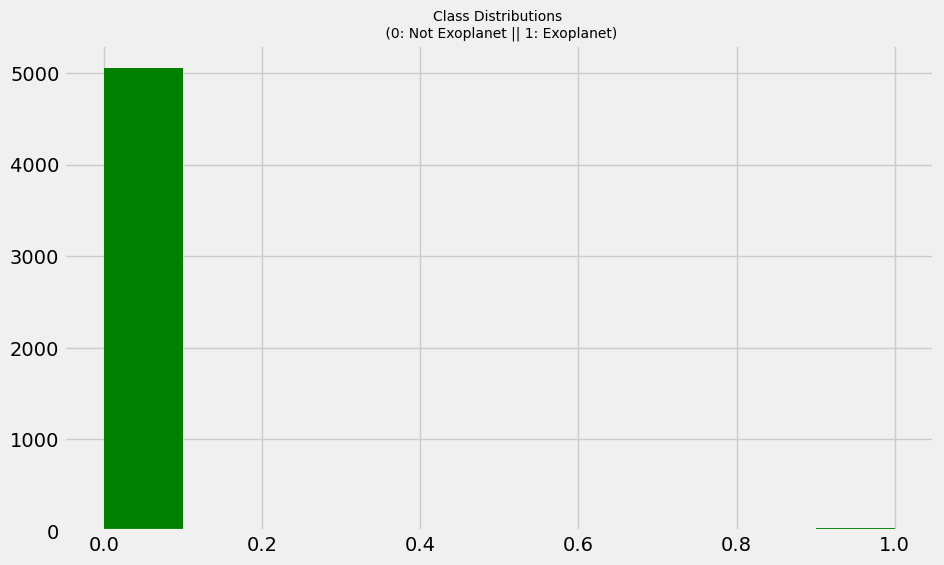

In [6]:
#Visualization:
#plt.figure(figsize=(6,4))
#colors = ["0", "1"]
#sns.histplot('LABEL', train_data, palette=colors)
#plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)
#The above is not working

#ADDED LATER
colors = ['green']
plt.hist(train_data['LABEL'], histtype ='bar',
         color = colors,
         label =colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=10)

In [7]:
train_data#.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.849998,83.809998,20.100000,-26.980000,-39.560001,-124.709999,-135.179993,-96.269997,-79.889999,...,-78.070000,-102.150002,-102.150002,25.129999,48.570000,92.540001,39.320000,61.419998,5.080000,-39.540001
1,1,-38.880001,-33.830002,-58.540001,-40.090000,-79.309998,-72.809998,-86.550003,-85.330002,-83.970001,...,-3.280000,-32.209999,-32.209999,-24.889999,-4.860000,0.760000,-11.700000,6.460000,16.000000,19.930000
2,1,532.640015,535.919983,513.729980,496.920013,456.450012,466.000000,464.500000,486.390015,436.559998,...,-71.690002,13.310000,13.310000,-29.889999,-20.879999,5.060000,-11.800000,-28.910000,-70.019997,-96.669998
3,1,326.519989,347.390015,302.350006,298.130005,317.739990,312.700012,322.329987,311.309998,312.420013,...,5.710000,-3.730000,-3.730000,30.049999,20.030001,-12.670000,-8.770000,-17.309999,-17.350000,13.980000
4,1,-1107.209961,-1112.589966,-1118.949951,-1095.099976,-1057.550049,-1034.479980,-998.340027,-1022.710022,-989.570007,...,-594.369995,-401.660004,-401.660004,-357.239990,-443.760010,-438.540009,-399.709991,-384.649994,-411.790009,-510.540009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,-91.910004,-92.970001,-78.760002,-97.330002,-68.000000,-68.239998,-75.480003,-49.250000,-30.920000,...,139.949997,147.259995,156.949997,155.639999,156.360001,151.750000,-24.450001,-17.000000,3.230000,19.280001
5083,0,989.750000,891.010010,908.530029,851.830017,755.109985,615.780029,595.770020,458.869995,492.839996,...,-26.500000,-4.840000,-76.300003,-37.840000,-153.830002,-136.160004,38.029999,100.279999,-45.639999,35.580002
5084,0,273.390015,278.000000,261.730011,236.990005,280.730011,264.899994,252.919998,254.880005,237.600006,...,-26.820000,-53.889999,-48.709999,30.990000,15.960000,-3.470000,65.730003,88.419998,79.070000,79.430000
5085,0,3.820000,2.090000,-3.290000,-2.880000,1.660000,-0.750000,3.850000,-0.030000,3.280000,...,10.860000,-3.230000,-5.100000,-4.610000,-9.820000,-1.500000,-4.650000,-14.550000,-6.410000,-2.550000


In [8]:
#(train_data.iloc[0,])

In [9]:
#plt.plot(train_data['FLUX.1'])

### FLUX1-FLUX3197 gives the light intensity recorded for each star, at a different point in time.

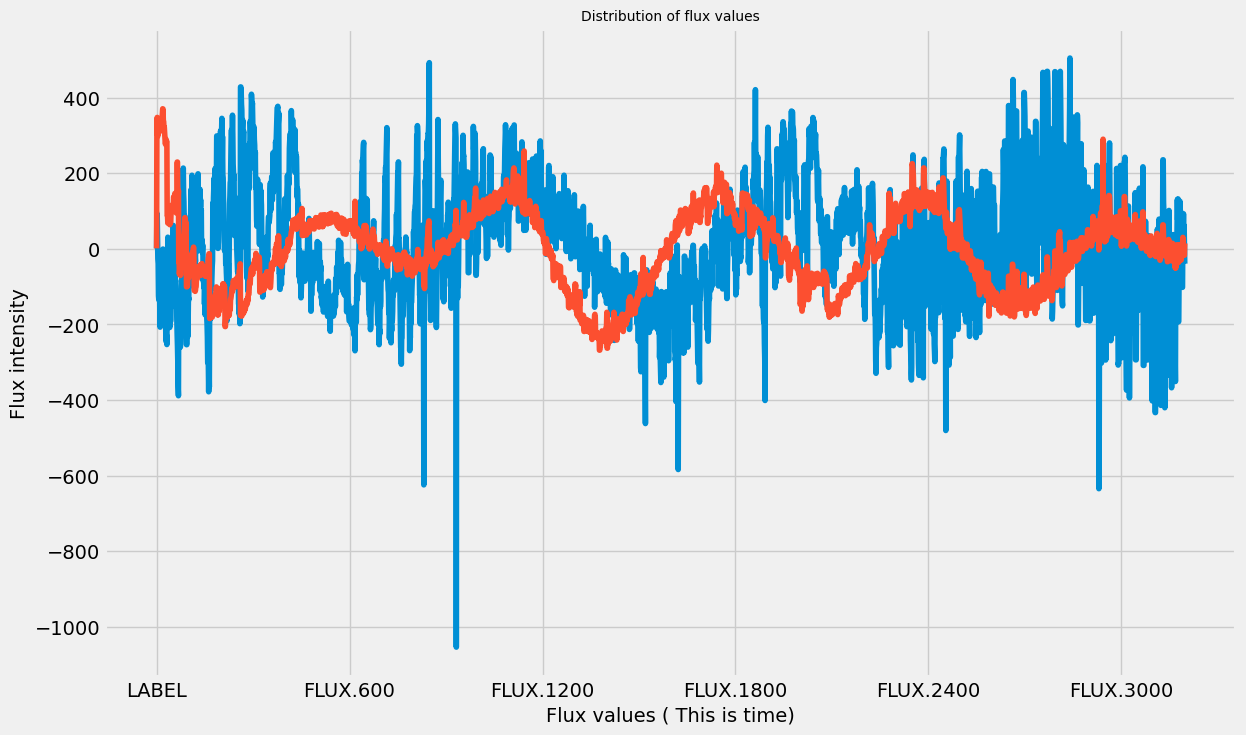

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values ( This is time)')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
#plt.plot(train_data.iloc[1,])
#plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.xticks(np.arange(0, 3197, 600)) #this fixes the problem with too many ticks

plt.show()



### These are lightcurves that have no gap in observation but these are not normalized. 

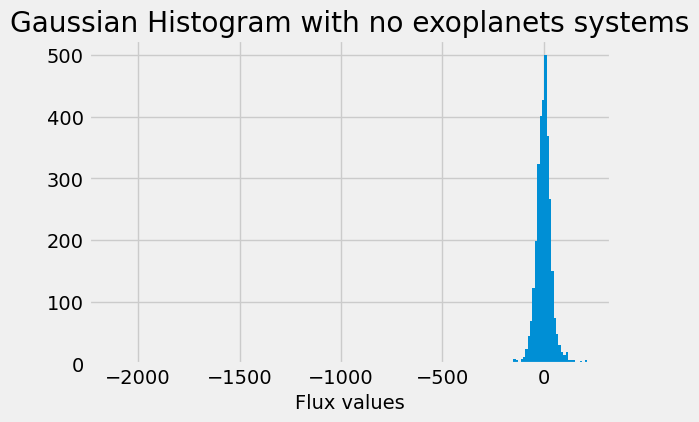

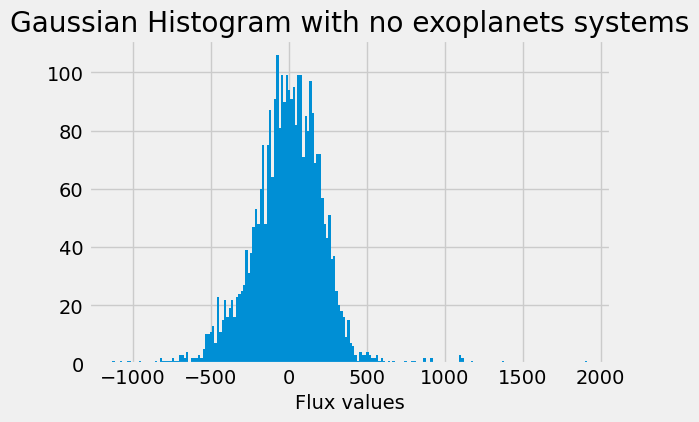

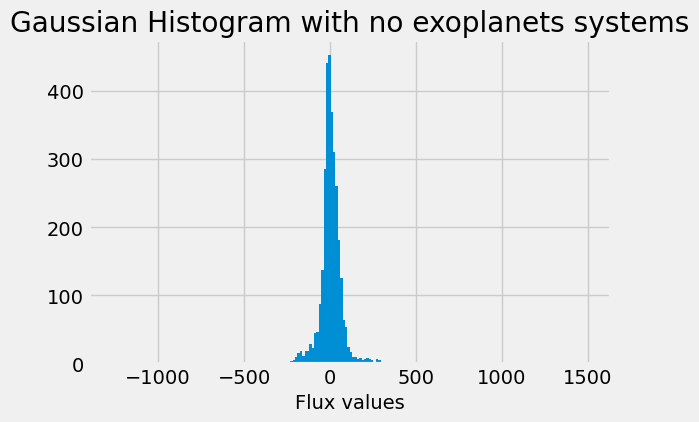

In [11]:
#Gaussian histogram of no exoplanets
rcParams['figure.figsize'] = 6,4
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram with no exoplanets systems")
    plt.xlabel("Flux values")
    plt.show()


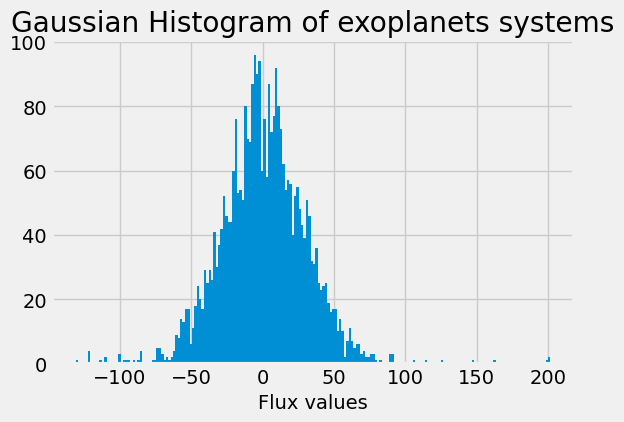

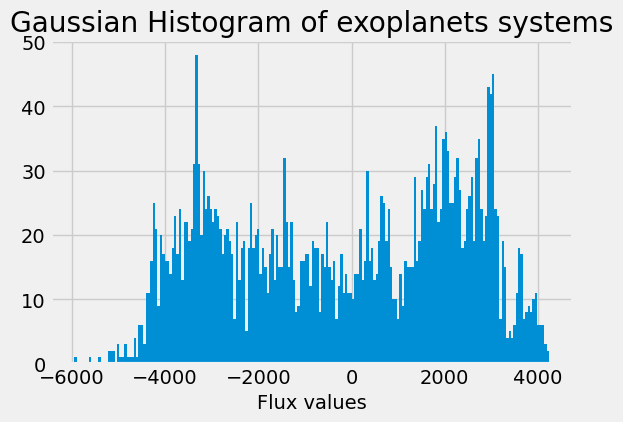

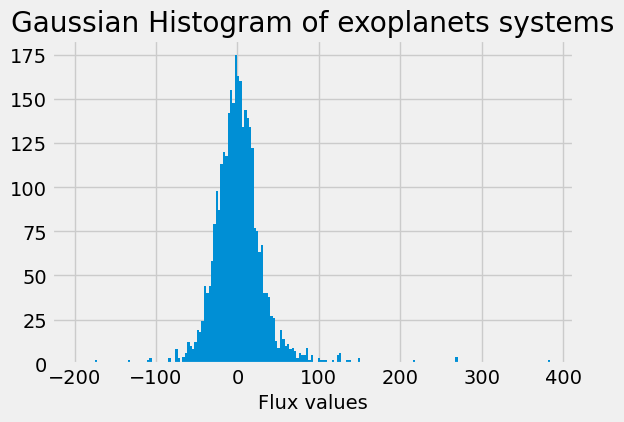

In [12]:
#Gaussian histogram of exoplanets
rcParams['figure.figsize'] = 6,4
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram of exoplanets systems")
    plt.xlabel("Flux values")
    plt.show()

### splitting the test abd training data into labels and the rest of the data.
### y_train and y_test has the labels of the training and test set respectively.

In [13]:

x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]


In [14]:
print("length of x_train=", len(x_train))
print("length of x_test=", len(x_test))

length of x_train= 5087
length of x_test= 570


In [15]:
#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)


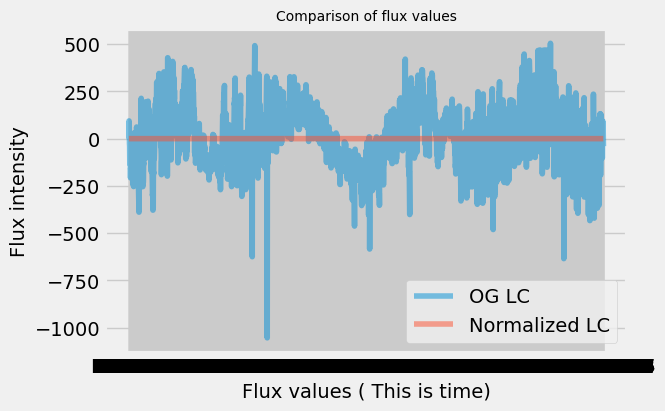

In [16]:
plt.plot(train_data.iloc[0,],label='OG LC', alpha=0.5)
plt.plot(x_train[0],label='Normalized LC', alpha=0.5)

rcParams['figure.figsize'] = 13, 8
plt.title('Comparison of flux values', fontsize=10)
plt.xlabel('Flux values ( This is time)')
plt.ylabel('Flux intensity')
plt.legend()

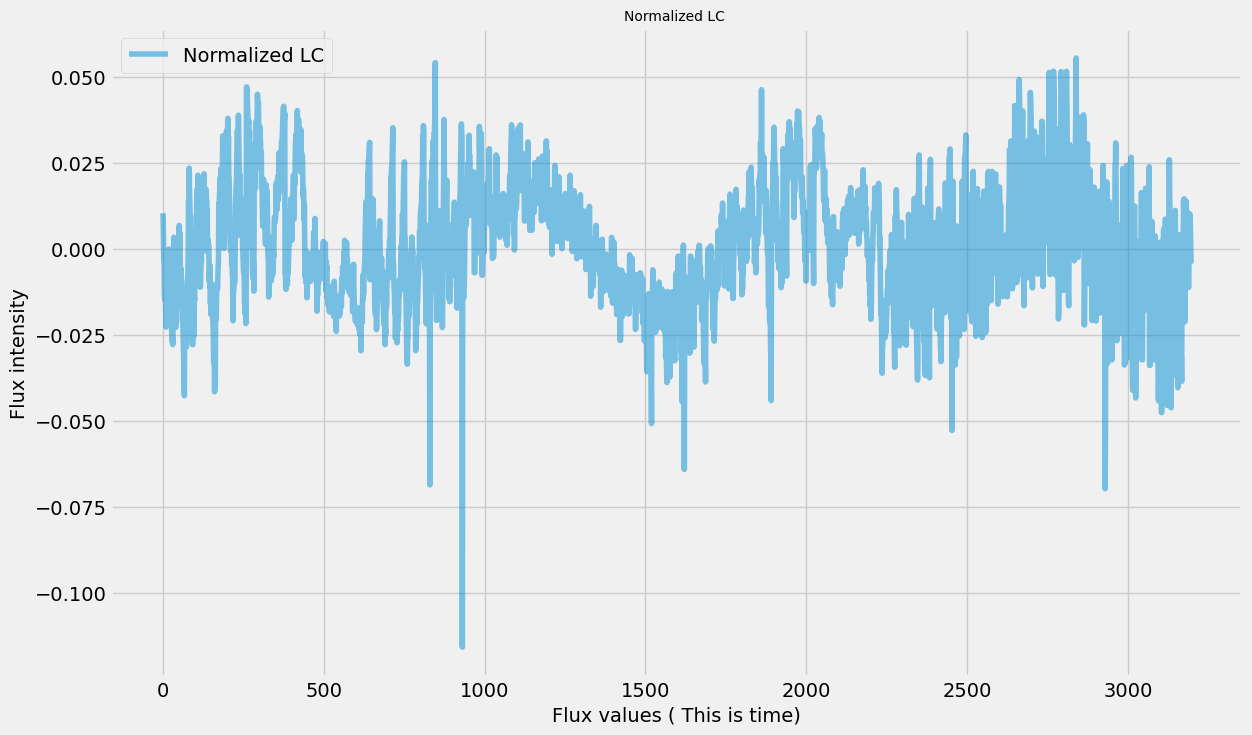

In [17]:
plt.plot(x_train[0],label='Normalized LC', alpha=0.5)
rcParams['figure.figsize'] = 13, 8
plt.title('Normalized LC ', fontsize=10)
plt.xlabel('Flux values ( This is time)')
plt.ylabel('Flux intensity')
plt.legend()

L1 normalization is a type of data normalization that scales each sample (i.e., row) of a dataset so that the sum of the absolute values of the elements in the sample is equal to 1. Mathematically, for a given row vector x, the normalized row vector x_norm is calculated as:

makefile

x_norm = x / ||x||_1

where ||x||_1 is the L1 norm of x, given by:

||x||_1 = |x_1| + |x_2| + ... + |x_n|

where n is the length of the vector.

Compared to L2 normalization, which scales each sample to have unit norm (i.e., length 1), L1 normalization places more emphasis on the relative magnitudes of the individual elements in the sample. This can be useful in situations where the absolute values of the elements are more important than their relative magnitudes, or when the dataset contains outliers or heavy-tailed distributions that can skew the normalization.

In scikit-learn, L1 normalization can be applied to a dataset using the normalize function with the norm='l1' parameter:



In [18]:
#Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

### Comparison of orginal data and data after normalization and gaussian filter

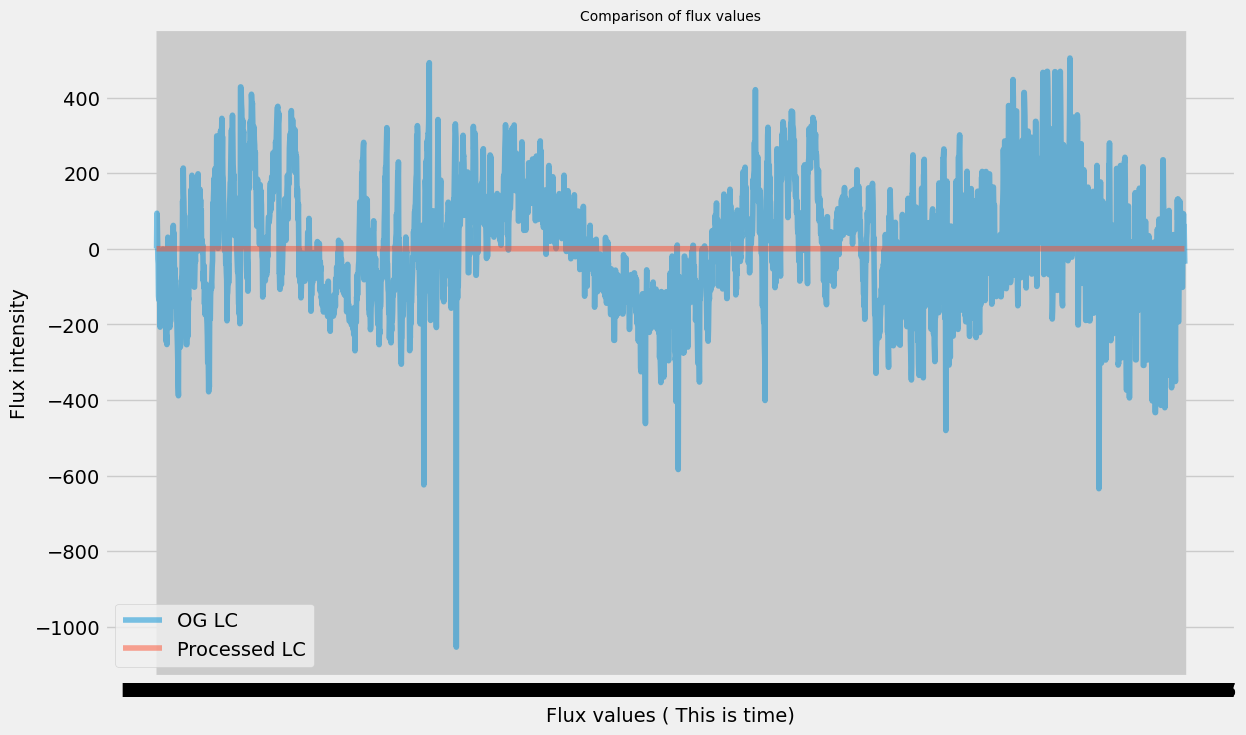

In [19]:

plt.plot(train_data.iloc[0,],label='OG LC', alpha=0.5)
plt.plot(x_train[0],label='Processed LC', alpha=0.5)

rcParams['figure.figsize'] = 13, 8
plt.title('Comparison of flux values', fontsize=10)
plt.xlabel('Flux values ( This is time)')
plt.ylabel('Flux intensity')
plt.legend()

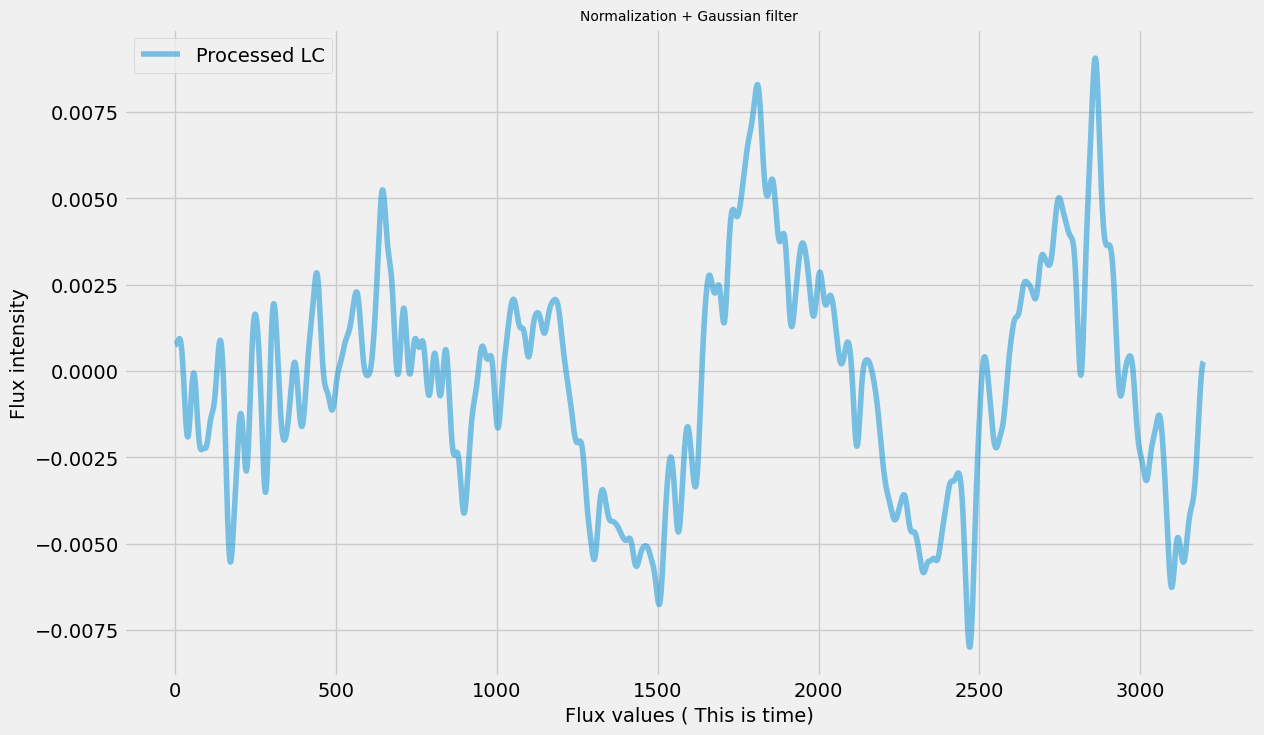

In [20]:
plt.plot(x_train[0],label='Processed LC', alpha=0.5)

rcParams['figure.figsize'] = 13, 8
plt.title('Normalization + Gaussian filter', fontsize=10)
plt.xlabel('Flux values ( This is time)')
plt.ylabel('Flux intensity')
plt.legend()

### This curve is smoother than the previous one.

### Checking the SD and mean for the data that is normalized and then gaussian fitted

In [21]:
print("Mean of x_train=", x_train.mean())
print("Standard deviation of x_train=", x_train.std())
print("Mean of x_test=", x_test.mean())
print("Standard deviation of x_test=", x_test.std())


Mean of x_train= 0.00041155028
Standard deviation of x_train= 0.0021003312
Mean of x_test= 0.00057748135
Standard deviation of x_test= 0.0020839383


### So the mean is not 0 and SD is not unity. So we need to scale the data

In [22]:
#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

print("length of x_train=", len(x_train))
print("length of x_test=", len(x_test))

length of x_train= 5087
length of x_test= 570


### Checking the SD and mean for the scaled data

In [23]:
print("Mean of x_train=", x_train.mean())
print("Standard deviation of x_train=", x_train.std())
print("Mean of x_test=", x_test.mean())
print("Standard deviation of x_test=", x_test.std())

Mean of x_train= -1.1364008e-08
Standard deviation of x_train= 1.0000005
Mean of x_test= -2.0096194e-10
Standard deviation of x_test= 1.0


### Here the SD is 1 and mean is almost 0 for bothe the test and training data

### We have a huge data set. We need to reduce the dimensions of the data set.
### To perform PCA we have to choose the number of features/dimensions that we want in our data.

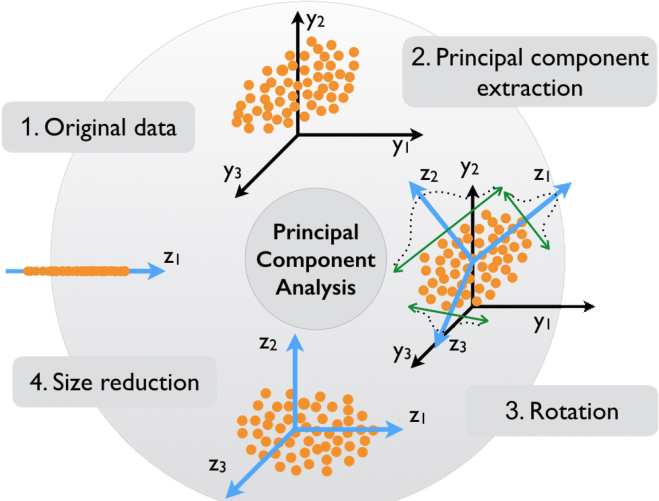

Credits : https://www.researchgate.net/figure/Schematic-overview-of-principal-component-analysis-Data-is-collected-principal_fig1_324331758

In [24]:
#Dimentioanlity reduction
from sklearn.decomposition import PCA
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
    
print('Required Dimensions = ',k)



Required Dimensions =  37


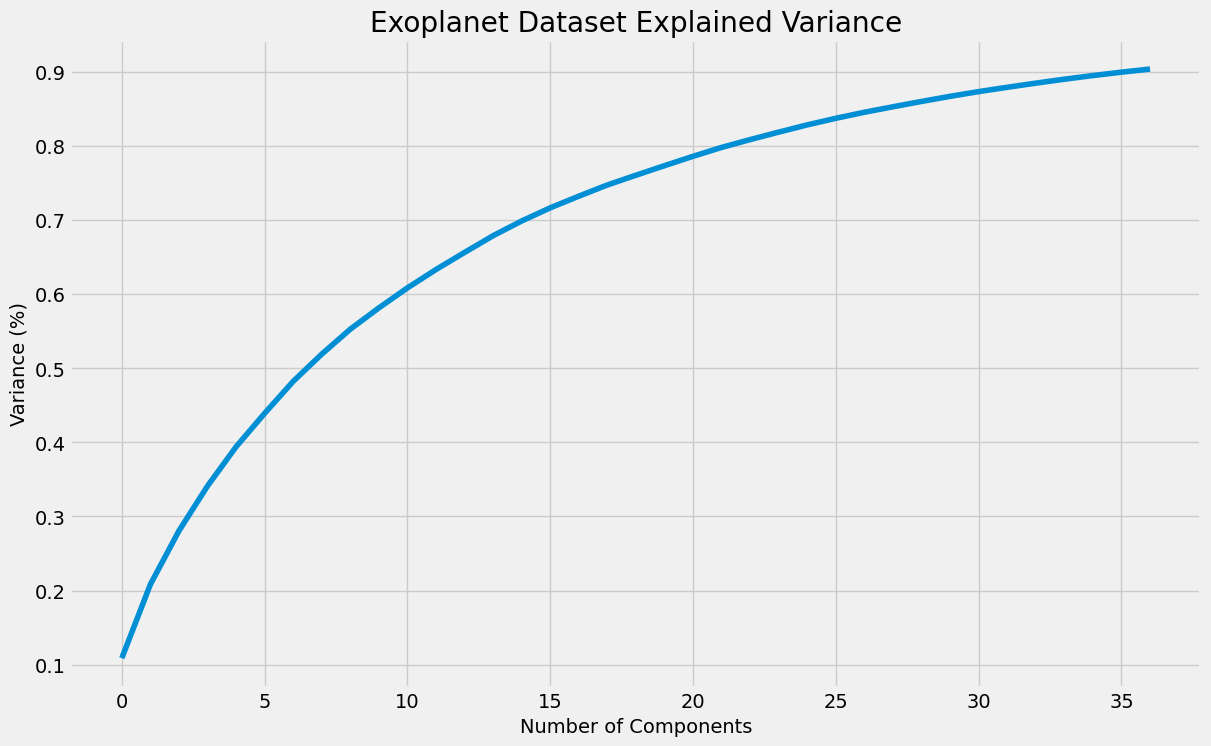

In [25]:
"""
This plot tells us that selecting 35 components we can preserve something around 98.8% or 99% 
of the total variance of the data. It makes sense, we’ll not use 100% of our variance,
because it denotes all components, and we want only the principal ones.
"""

#Apply PCA with n_componenets
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()
        

#### This code applies Principal Component Analysis (PCA) with 37 components to the x_train and x_test datasets.

In [26]:
len(x_train) # Number of objects remaining same

5087

In [27]:
len(x_train[0]) # Required columns reduce to 37 from 3198

37

In [28]:
x_train[0]

array([ 46.931107  ,  18.13813   ,  58.752964  ,  18.28621   ,
        24.953037  ,  19.835146  , -24.117788  , -31.489283  ,
        -2.8234217 ,  -3.6287336 ,   1.2425472 ,   8.504024  ,
       -18.161816  ,   0.53757054,  -9.052602  ,  11.809993  ,
       -10.90209   ,   4.4885526 ,  12.791149  ,   3.7855222 ,
         4.1034026 ,   9.276987  ,   2.0572398 ,   9.210702  ,
         2.2347581 ,   3.4683685 ,   0.7936317 , -10.113803  ,
         2.615527  ,  -2.2786505 ,  -8.52047   ,   2.763614  ,
         6.2916794 ,  -5.3937507 , -12.59833   ,  -3.4632566 ,
        -3.7421532 ], dtype=float32)

RangeIndex(start=0, stop=37, step=1)

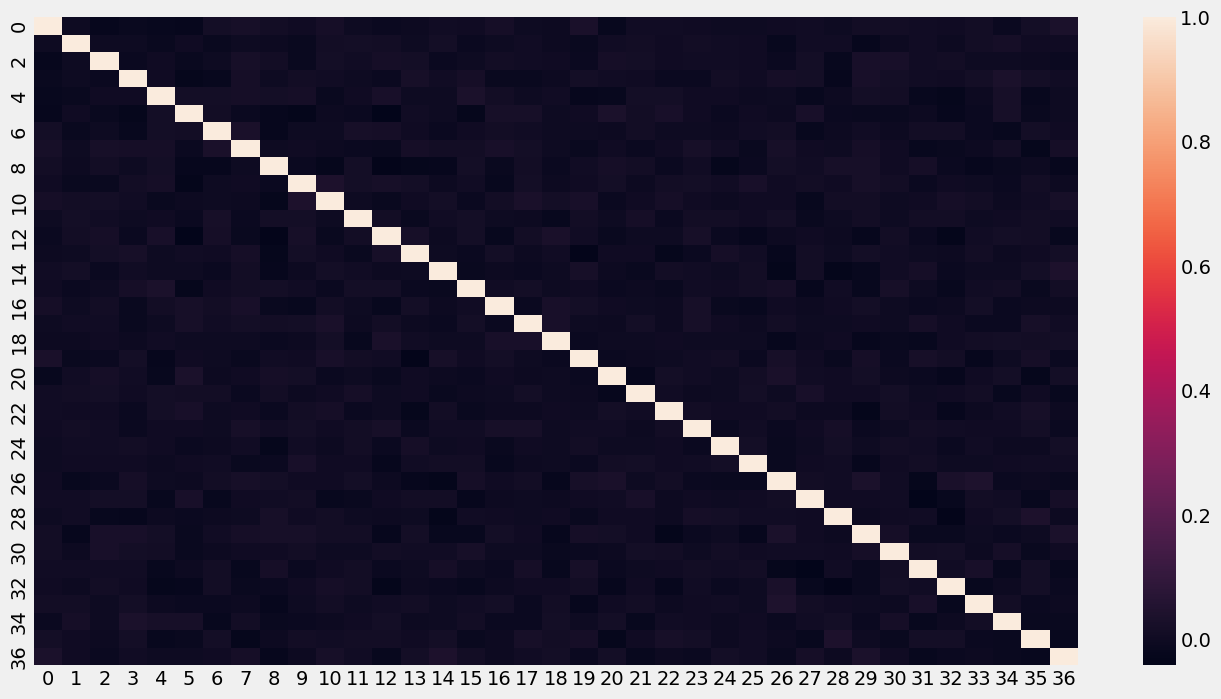

In [29]:
df = pd.DataFrame.from_records(x_train)     
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=False)#True)
df.columns

In [30]:
#Resampling as the data is highly unbalanced.
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=27, sampling_strategy = 1.0)   
#sampling_strategy was ratio before. It gave an error (TypeError: __init__() got 
#an unexpected keyword argument 'ratio' when using SMOTE)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel()) #Resample instead of sample

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


In [31]:
print("length of x_train_res=", len(x_train_res))
print("length of y_train_res=", len(x_train_res))

length of x_train_res= 10100
length of y_train_res= 10100


# ANN

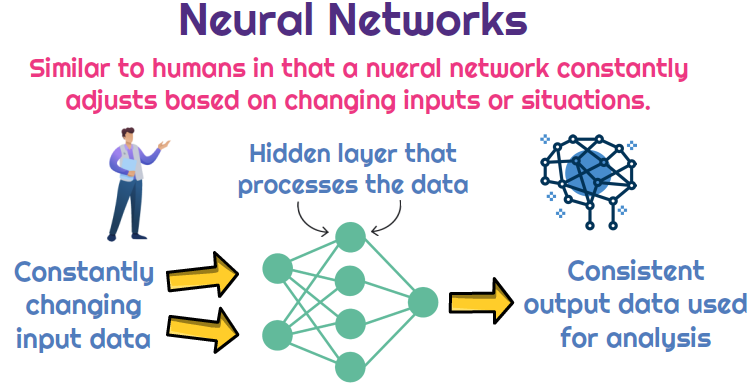

Credits: https://www.universalcpareview.com/ask-joey/what-is-a-neural-network-in-accounting-and-finance/

In [32]:
# Artificial Neural Network
#train an Artificial Neural Network on the training dataset using K-fold cross-validation.
#from tensorflow import set_random_seed


import tensorflow as tf
tf.random.set_seed(101)
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))


2023-05-17 21:23:20.952891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:23:27.683073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:23:27.683075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations: 

Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
Epoch 1/40
253/253 [==============================] - 27s 3ms/step - loss: 0.3518 - accuracy: 0.9068
Epoch 2/40
253/253 [==============================] - 27s 3ms/step - loss: 0.3721 - accuracy: 0.9765
Epoch 2/40
253/253 [==============================] - 1s 2ms/step - loss: 0.0746 - accuracy: 0.9901
Epoch 3/40
253/253 [==============================] - 1s 3ms/step - loss: 0.0338 - accuracy: 0.9934
Epoch 3/40
253/253 [==============================] - 1s 3ms/step - loss: 0.0947 - accuracy: 0.9855
Epoch 3/40
253/253 [==============================] - 1s 3ms/step - loss: 0.0276 - accuracy: 0.9985
Epoch 3/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0278 - accuracy: 0.9988
Epoch 3/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0305 - accuracy: 0.9986
Epoch 4/40
253/253 [==============================] - 1s 4ms/step - loss: 0.0112 - accuracy: 0.9984
Epoch 4/40
253/253 [==============================] - 

253/253 [==============================] - 0s 2ms/step - loss: 4.7152e-04 - accuracy: 1.0000
Epoch 15/40
253/253 [==============================] - 0s 2ms/step - loss: 4.4613e-04 - accuracy: 0.9999
Epoch 16/40
253/253 [==============================] - 0s 2ms/step - loss: 9.1836e-04 - accuracy: 0.9999
Epoch 16/40
253/253 [==============================] - 0s 2ms/step - loss: 4.9757e-04 - accuracy: 0.9998
Epoch 16/40
253/253 [==============================] - 1s 2ms/step - loss: 6.4749e-04 - accuracy: 0.9999
Epoch 15/40
253/253 [==============================] - 0s 2ms/step - loss: 3.7171e-04 - accuracy: 1.0000
Epoch 16/40
253/253 [==============================] - 0s 2ms/step - loss: 3.3735e-04 - accuracy: 0.9999
Epoch 17/40
253/253 [==============================] - 0s 2ms/step - loss: 6.3311e-04 - accuracy: 0.9999
Epoch 17/40
253/253 [==============================] - 0s 2ms/step - loss: 3.6959e-04 - accuracy: 0.9998
Epoch 17/40
253/253 [==============================] - 0s 2ms/step 

253/253 [==============================] - 0s 2ms/step - loss: 1.3554e-04 - accuracy: 1.0000
Epoch 31/40
Epoch 31/40
253/253 [==============================] - 0s 2ms/step - loss: 1.0255e-05 - accuracy: 1.0000
Epoch 31/40
253/253 [==============================] - 0s 2ms/step - loss: 5.5818e-05 - accuracy: 1.0000
Epoch 31/40
253/253 [==============================] - 0s 2ms/step - loss: 4.6051e-04 - accuracy: 0.9998
Epoch 30/40
253/253 [==============================] - 0s 2ms/step - loss: 1.0579e-04 - accuracy: 1.0000
Epoch 32/40
253/253 [==============================] - 0s 2ms/step - loss: 1.3804e-04 - accuracy: 1.0000
Epoch 32/40
253/253 [==============================] - 0s 2ms/step - loss: 8.7223e-06 - accuracy: 1.0000
Epoch 32/40
253/253 [==============================] - 0s 2ms/step - loss: 5.0649e-05 - accuracy: 1.0000
Epoch 32/40
253/253 [==============================] - 0s 2ms/step - loss: 5.5447e-04 - accuracy: 0.9998
Epoch 31/40
253/253 [==============================] - 

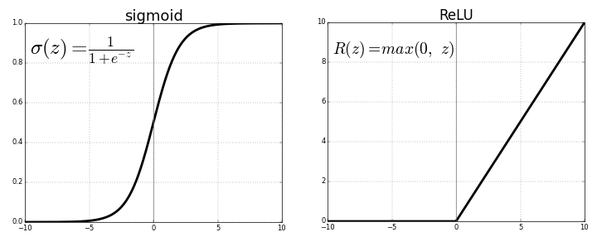

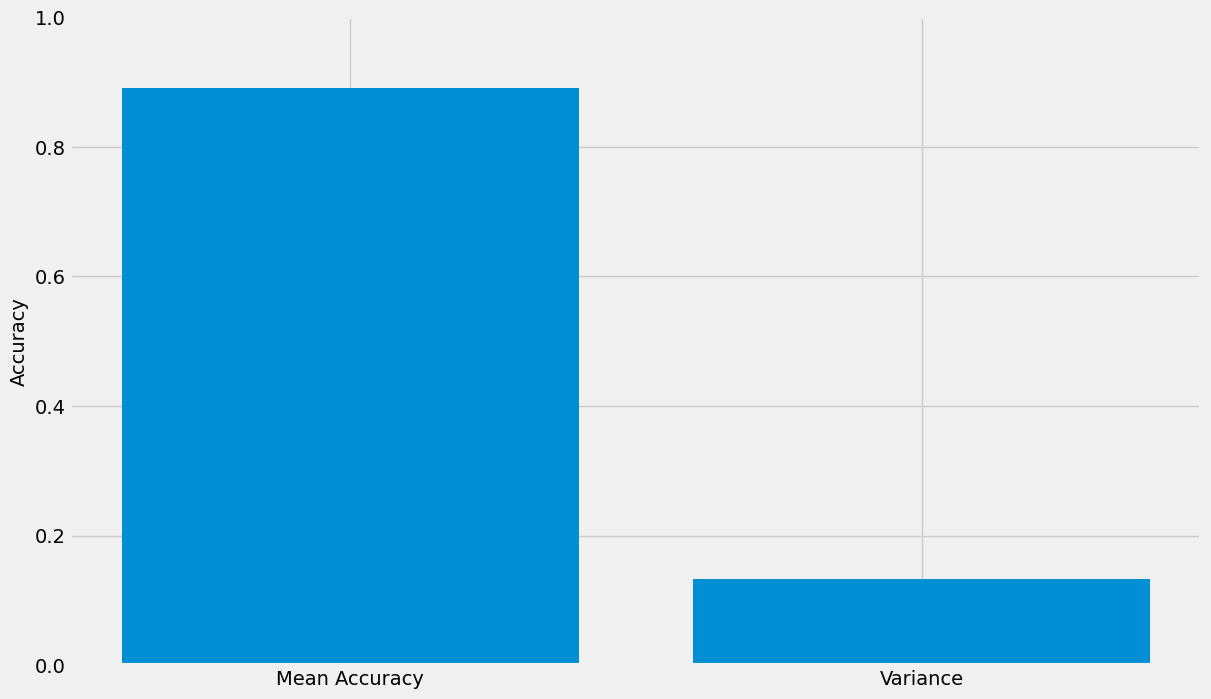

In [33]:
#ADDED LATER

plt.bar(['Mean Accuracy', 'Variance'], [mean, variance])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()

# BEGIN TEST

In [34]:
#Use this on a test set
#To use the trained model on a test set, you can first fit the model on the entire training set using the 
#fit method of the KerasClassifier object:
# So i am fitting the model on the resampled/oversampled data of length 10100


classifier.fit(x_train_res, y_train_res)

2023-05-17 21:24:53.077615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:24:53.081802: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/40
316/316 [==============================] - 2s 4ms/step - loss: 0.3437 - accuracy: 0.8771
Epoch 2/40
316/316 [==============================] - 5s 14ms/step - loss: 0.0218 - accuracy: 0.9961
Epoch 3/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0060 - accuracy: 0.9997
Epoch 4/40
316/316 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 0.9998
Epoch 5/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 6/40
316/316 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 7/40
316/316 [==============================] - 4s 12ms/step - loss: 7.4641e-04 - accuracy: 0.9999
Epoch 8/40
316/316 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 9/40
316/316 [==============================] - 1s 3ms/step - loss: 5.5391e-04 - accuracy: 0.9999
Epoch 10/40
316/316 [==============================] - 1s 3ms/step - loss: 4.6113e-04 - ac

In [34]:
#Then, you can use the predict method of the trained model to make predictions on the oversampled test set:

y_pred = classifier.predict(x_test)  #x_test also has pca done on it
                                    #This is the original test data.

18/18 [==============================] - 0s 6ms/step


# Here I am fitting the model on the resampled training set. 
# But using this on the original test data we had. 

In [35]:
#x_test

In [36]:
#y_pred

In [37]:
# Evaluate the performance of the model on the test set
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
#print("Test set accuracy: ", accuracy)


print('Test accuracy score is', accuracy_score(y_test, y_pred))
print ("\nClassification report :\n",(classification_report(y_test,y_pred)))


Test accuracy score is 0.9631578947368421

Classification report :
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       565
           1       0.00      0.00      0.00         5

    accuracy                           0.96       570
   macro avg       0.50      0.49      0.49       570
weighted avg       0.98      0.96      0.97       570



18/18 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

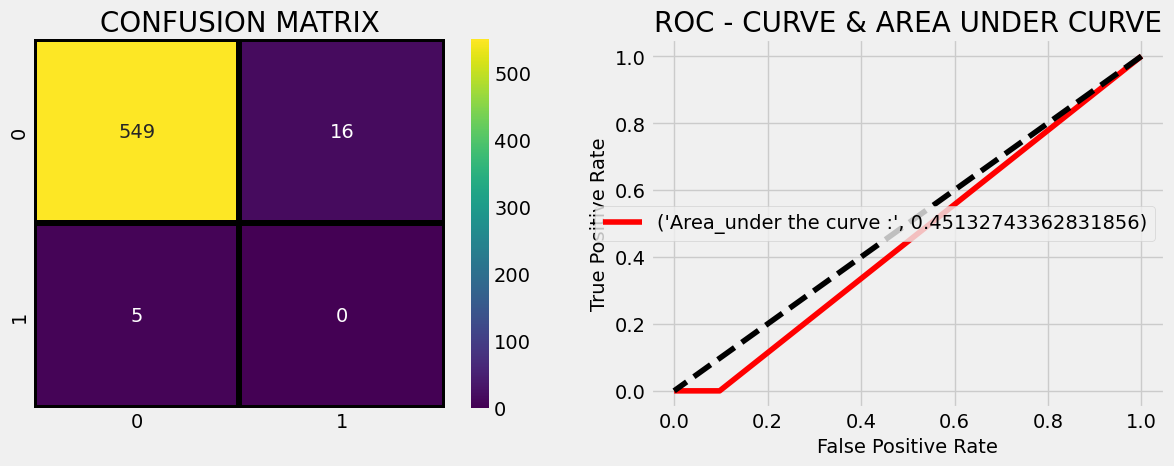

In [38]:
#Plot data

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
#plot_confusion_matrix(classifier, x_test, y_test)

#ROC curve and Area under the curve plotting

y_pred_prob = classifier.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

#fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)



### Here the while non-exoplanets are classified wee, exoplanets are not well classified. Area under the ROC curve is low and so binary classification is not well. 

# END TEST

# Splitting the oversampled training set into new test and training sets

In [39]:
train_X, test_X, train_y, test_y = train_test_split(x_train_res, y_train_res, test_size=0.33, random_state=42)

In [40]:
classifier.fit(train_X,train_y)

Epoch 1/40
212/212 [==============================] - 1s 2ms/step - loss: 0.4086 - accuracy: 0.8534
Epoch 2/40
212/212 [==============================] - 1s 2ms/step - loss: 0.1580 - accuracy: 0.9716
Epoch 3/40
212/212 [==============================] - 1s 2ms/step - loss: 0.0818 - accuracy: 0.9956
Epoch 4/40
212/212 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.9991
Epoch 5/40
212/212 [==============================] - 1s 2ms/step - loss: 0.0164 - accuracy: 0.9999
Epoch 6/40
212/212 [==============================] - 1s 3ms/step - loss: 0.0097 - accuracy: 0.9999
Epoch 7/40
212/212 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.9999
Epoch 8/40
212/212 [==============================] - 0s 1ms/step - loss: 0.0045 - accuracy: 0.9999
Epoch 9/40
212/212 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.9999
Epoch 10/40
212/212 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.9999

In [41]:
y_pred = classifier.predict(test_X)

105/105 [==============================] - 0s 3ms/step


In [42]:
print('Validation accuracy of Decision Tree is', accuracy_score(y_pred,test_y))
print ("\nClassification report :\n",(classification_report(test_y,y_pred)))

Validation accuracy of Decision Tree is 0.9996999699969997

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1700
           1       1.00      1.00      1.00      1633

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



Text(0.5, 1.0, 'CONFUSION MATRIX')

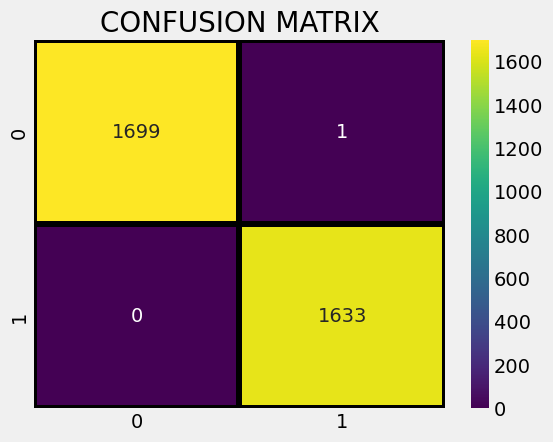

In [43]:
#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(test_y,y_pred),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)




105/105 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

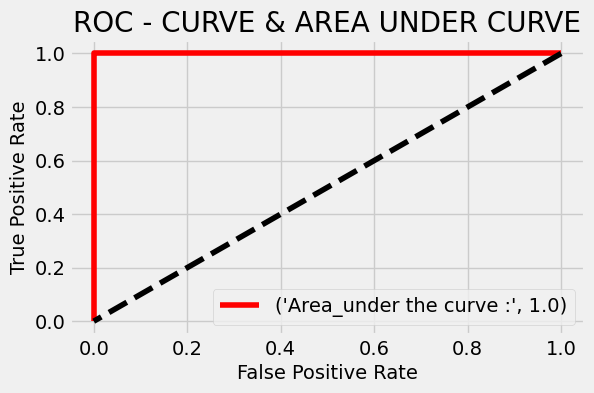

In [44]:
#ROC curve and Area under the curve plotting

y_pred_prob = classifier.predict_proba(test_X)[:, 1]

fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
roc_auc = auc(fpr, tpr)

#fpr,tpr,thresholds = roc_curve(test_y,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

# Here we see that classification is good. 

# SVM

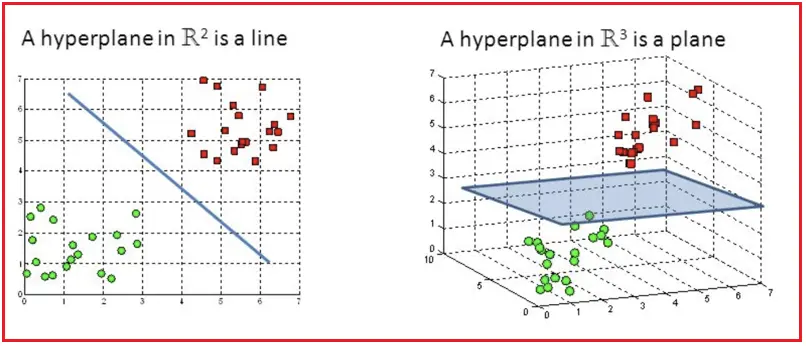

Credits: https://dotnettutorials.net/lesson/svms-in-machine-learning/

In [46]:
def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    #fit the model
    classifier.fit(dtrain_x,dtrain_y)
    predictions = classifier.predict(dtest_x)

    #Cross validation
    accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
    mean = accuracies.mean()
    variance = accuracies.std()
    print("Accuracy mean: "+ str(mean))
    print("Accuracy variance: "+ str(variance))

    #Accuracy
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))

    #Classification report
    print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))

    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)

Accuracy mean: 0.9991089108910891
Accuracy variance: 0.0017821782178217838

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



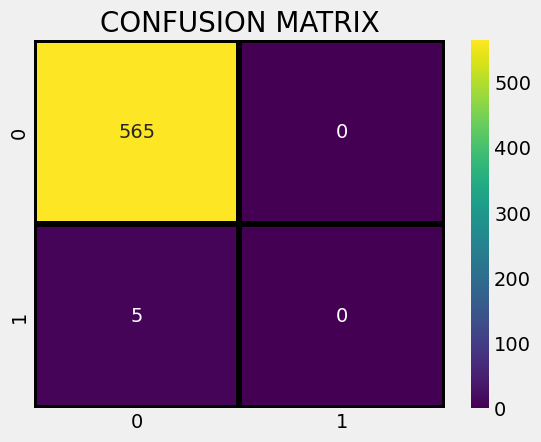

In [47]:
from sklearn.svm import SVC
SVM_model=SVC()
model(SVM_model,x_train_res,y_train_res,x_test,y_test)

# RANDOM FOREST

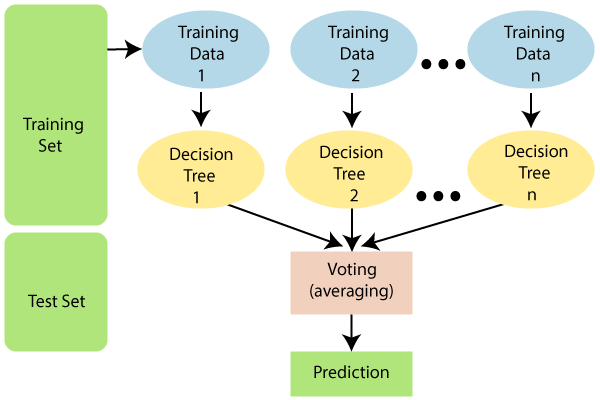

Credits : https://www.javatpoint.com/machine-learning-random-forest-algorithm

In [56]:
#Display feature importance   
df1 = pd.DataFrame.from_records(x_train)     


In [59]:
df1

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,46.931332,18.138073,58.753021,18.286127,24.953033,19.835028,-24.117847,-31.489418,-2.823008,-3.628675,...,-10.107922,2.621000,-2.286201,-8.528818,2.737993,6.251302,-5.393359,-12.599172,-3.365151,-3.782083
1,46.963173,18.151525,58.490219,18.449085,24.777435,19.638266,-23.712467,-31.261906,-2.828312,-3.523594,...,-9.944898,2.579391,-2.329618,-8.483206,2.653065,6.269173,-5.319426,-12.541267,-3.362100,-3.783083
2,47.028160,18.182220,57.968121,18.770697,24.433174,19.249645,-22.914835,-30.815563,-2.840239,-3.320931,...,-9.623797,2.496269,-2.414685,-8.396505,2.489370,6.303454,-5.173321,-12.422412,-3.356190,-3.785960
3,47.122810,18.224007,57.196209,19.244070,23.930016,18.678951,-21.748251,-30.165333,-2.854666,-3.028876,...,-9.150681,2.371308,-2.540072,-8.266049,2.247275,6.354451,-4.960910,-12.245016,-3.343283,-3.786260
4,47.244102,18.282782,56.185223,19.858694,23.286308,17.942150,-20.245070,-29.330212,-2.872435,-2.664874,...,-8.535409,2.202638,-2.701397,-8.097827,1.936910,6.420330,-4.687069,-12.008207,-3.321375,-3.780649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,-18.567915,-32.553169,5.493452,-10.356553,13.807753,-19.130384,21.911715,-10.947329,6.794790,-5.656255,...,13.032534,-3.576755,-14.414134,5.965370,4.939971,8.012722,-4.641196,5.688134,-5.951946,-4.670433
5083,-18.805899,-33.176998,5.611276,-10.442365,14.335040,-19.253069,21.356518,-10.594861,6.635403,-5.796977,...,13.088308,-3.618235,-14.543408,6.024290,5.416853,8.413319,-4.728788,5.845823,-5.900731,-4.573833
5084,-18.982458,-33.633171,5.700090,-10.502198,14.743327,-19.352758,20.921076,-10.330680,6.515367,-5.904600,...,13.127891,-3.649227,-14.640685,6.067997,5.786738,8.718074,-4.797557,5.967998,-5.858763,-4.498661
5085,-19.098879,-33.932171,5.759185,-10.540385,15.021652,-19.424082,20.620914,-10.154541,6.435682,-5.974520,...,13.154013,-3.669132,-14.705342,6.096582,6.038857,8.923419,-4.844722,6.051186,-5.828818,-4.446822


Accuracy mean: 0.9999009900990099
Accuracy variance: 0.0001980198019801982

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



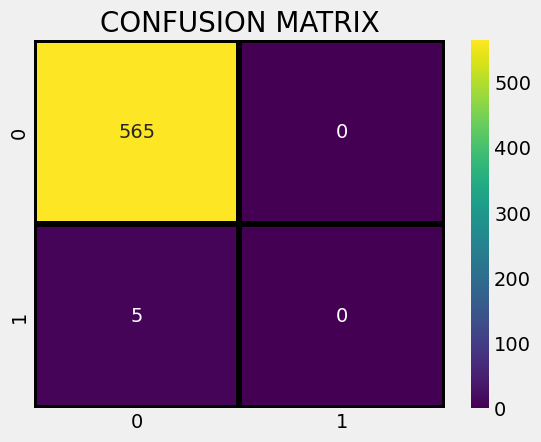

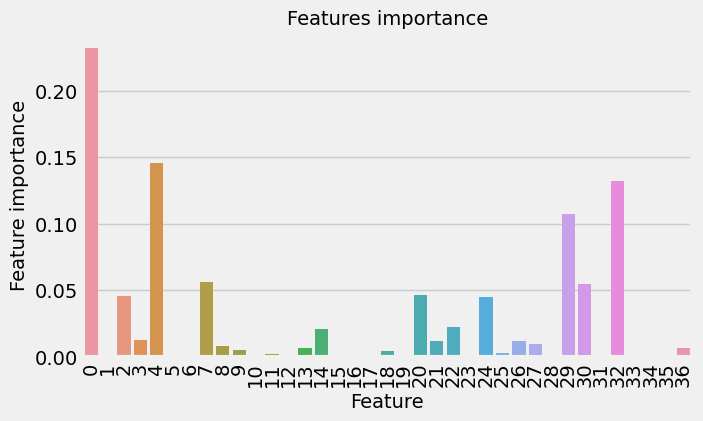

In [64]:
#and call the Random forest classification algorithm.
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()

model(rf_classifier,x_train_res,y_train_res,x_test,y_test)

tmp = pd.DataFrame({'Feature': df1.columns, 'Feature importance': rf_classifier.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()